In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import CSV File

volatility_df = pd.read_csv("UpdatedGammaVix.csv")

In [3]:
volatility_df

,date,price,Vix Previous Close,Vix 21 Moving Average,SPX Change,DIX Previous Close,GEX Previous Close,MOVE
0,5/31/11,1345.199951,15.980000,16.911429,0.010593,0.400935,9.186650e+08,71.50
1,6/1/11,1314.550049,15.450000,17.021429,-0.022785,0.402477,1.501019e+09,72.90
2,6/2/11,1312.939941,18.299999,17.087619,-0.001225,0.441582,7.654729e+08,76.60
3,6/3/11,1300.160034,18.090000,17.129048,-0.009734,0.413070,7.370545e+08,75.90
4,6/6/11,1286.170044,17.950001,17.142857,-0.010760,0.436110,4.059565e+08,75.80
...,...,...,...,...,...,...,...,...
2879,11/4/22,3770.550049,25.299999,29.209524,0.013619,0.442476,-6.368992e+08,128.44
2880,11/7/22,3806.800049,24.549999,28.875714,0.009614,0.425303,5.863258e+08,128.33
2881,11/8/22,3828.110107,24.350000,28.546667,0.005598,0.449861,1.164755e+09,126.33
2882,11/9/22,3748.570068,25.540001,28.187619,-0.020778,0.438960,1.395167e+09,124.40


In [4]:
# Create data frame with SPX and Gamma levels

spx_gamma_df = volatility_df[["SPX Change", "GEX Previous Close"]]

Text(0.5, 1.0, 'SPX Change by GEX level')

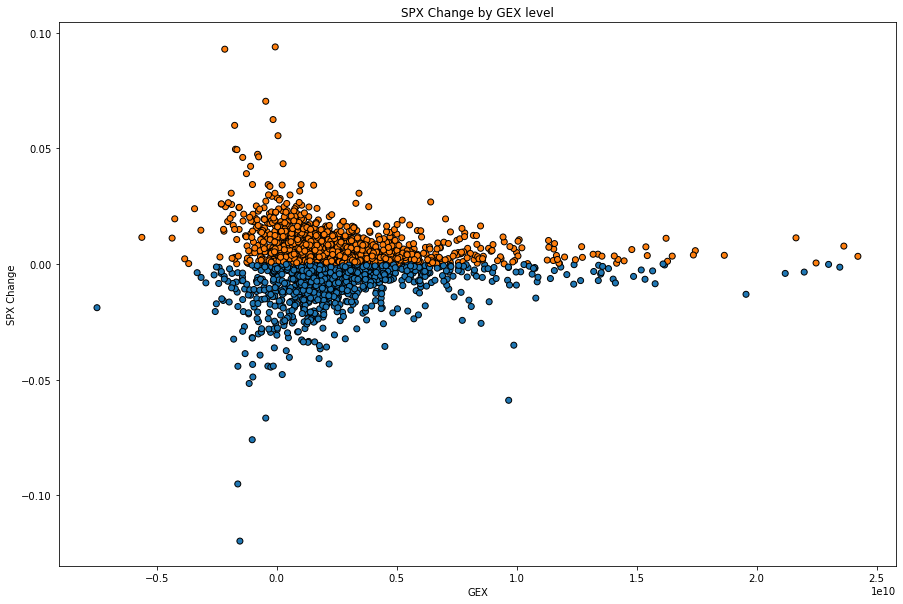

In [5]:
# Graph Relationship between Gamma and SPX Movement

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10
colors = np.where(spx_gamma_df["SPX Change"] <0, 'C0', 'C1')
plt.scatter(x = spx_gamma_df["GEX Previous Close"], y = spx_gamma_df["SPX Change"],cmap = 'Spectral', edgecolor = 'k', c= colors)
plt.xlabel("GEX")
plt.ylabel("SPX Change")
plt.title("SPX Change by GEX level")

In [6]:
# Calculate Absolute Moves in SPX

volatility_df["Absolute SPX Change"] = volatility_df["SPX Change"].abs()

Text(0.5, 1.0, 'Absolute SPX Change by GEX level')

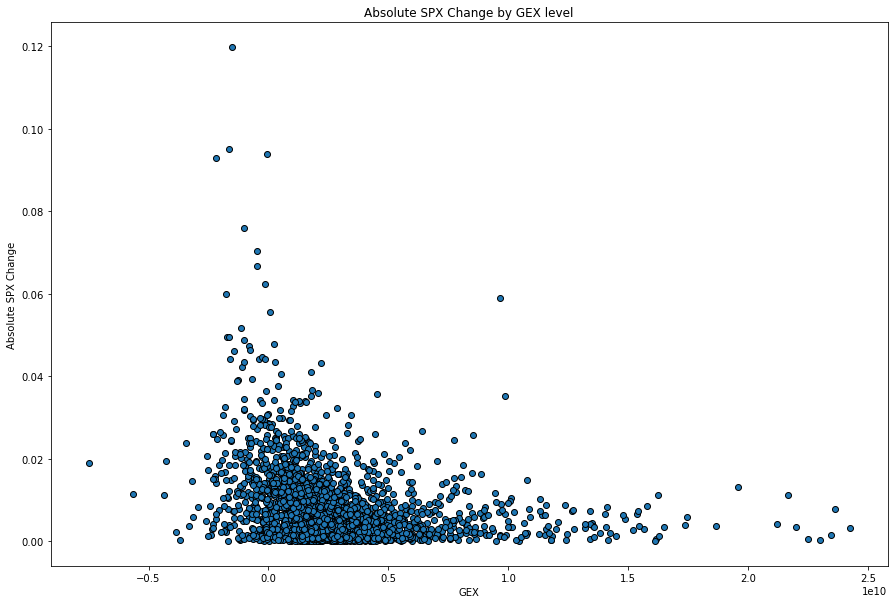

In [7]:
# Graph SPX Change in Absolute move

plt.scatter(x = volatility_df["GEX Previous Close"], y = volatility_df["Absolute SPX Change"],cmap = 'Spectral', edgecolor = 'k')
plt.xlabel("GEX")
plt.ylabel("Absolute SPX Change")
plt.title("Absolute SPX Change by GEX level")

In [8]:
### Observation: In the above graph we see that Gamma Exposure (GEX) plays a big role in determining the 
### day-to-day volatility of the S&P 500 (SPX). As Gamma Exposure increases, the S&P contracts in volatility. 
### As Gamma decreases, S&P volatility increases and we experience wider trading ranges. Due to what this graph shows,
### we believe that we can find a relationship between Actual Realized volatility and Gamma Exposure. Our goal is to 
### find the relationship, and then see if we can compare that to the Implied Volatility to gain a trading edge. 

In [9]:
# Download S&P 500 ETF (SPY) data and create DataFrame

spy_df = yf.download("SPY")

[*********************100%***********************]  1 of 1 completed


In [10]:
# Calculate the Daily Change in S&P 500 ETF

spy_df["Daily Return"] = spy_df["Adj Close"].pct_change()

In [11]:
# Drop Columns

spy_df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)

In [12]:
# Download CBOE Volatility Index (VIX) data and create DataFrame

vix_df = yf.download("^VIX", start="1993-01-29")

[*********************100%***********************]  1 of 1 completed


In [13]:
# Use "Rule of 16" to determine the One-Day Implied Move in Market

vix_df["Implied One-Day Move"] = (vix_df["Close"] / np.sqrt(252))/100

In [14]:
# Drop Columns

vix_df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)

In [15]:
# Concatenate VIX and SPY DataFrames

spy_vix_df = pd.concat([spy_df, vix_df], axis=1)

In [16]:
# Drop Columns

spy_vix_df.drop(columns=["Adj Close"], inplace=True)

In [17]:
# Display the Absolute Daily Move in S&P 500 ETF

spy_vix_df["Absolute Daily Return"] = spy_vix_df["Daily Return"].abs()

In [18]:
# Calculate Spread between Implied and Realized Volatility

spy_vix_df["Implied vs. Realized Spread"] =spy_vix_df["Implied One-Day Move"] - spy_vix_df["Absolute Daily Return"]

In [19]:
# Show Stats for Implied vs Realized Spread

spy_vix_df["Implied vs. Realized Spread"].describe()

count    7504.000000
mean        0.004509
std         0.007342
min        -0.110557
25%         0.001440
50%         0.005477
75%         0.008446
max         0.043231
Name: Implied vs. Realized Spread, dtype: float64

Text(0.5, 1.0, 'History of Implied vs Realized Volatility')

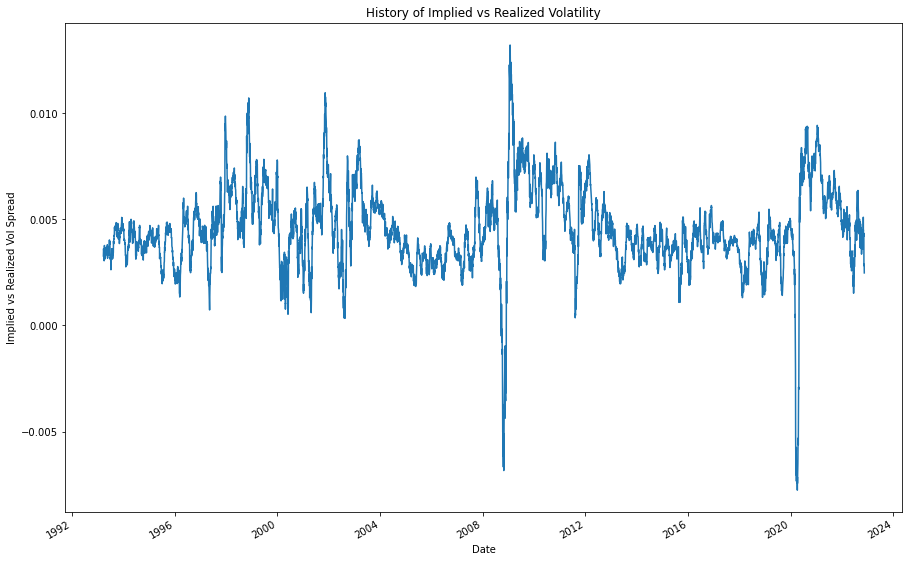

In [20]:
# Plot the 35 day rolling average in Implied vs. Realized Volatility

spy_vix_df["Implied vs. Realized Spread"].rolling(35).mean().plot()
plt.xlabel("Date")
plt.ylabel("Implied vs Realized Vol Spread")
plt.title("History of Implied vs Realized Volatility")

In [21]:
###  Observation: The chart above shows that there is, generally, a premium that is paid by those who buy puts. This
### premium is shown from the spread between Implied vs Realized (Actual) volatility. The chart shows that on average, there is 
### a premium of about 45 basis points over the time span. This means that for a majority of the time, shorting 
### volatility is a profitable strategy. However, As one can see in 2008 and 2020, shorting volatility can be very
### dangerous. This is why it is important to not just short volatility blindly as many funds do. This graph also 
### shows us that some of the best times to short volatility, is right after the worst times. 

In [22]:
### This chart above shows the basis for our project. As the chart shows there is a correct time to short volatility
### and there is an incorrect time to short volatility, and instead buy it. For our project, we aim to better predict
### when to do which. 

In [23]:
volatility_df.head()

,date,price,Vix Previous Close,Vix 21 Moving Average,SPX Change,DIX Previous Close,GEX Previous Close,MOVE,Absolute SPX Change
0,5/31/11,1345.199951,15.980000,16.911429,0.010593,0.400935,9.186650e+08,71.5,0.010593
1,6/1/11,1314.550049,15.450000,17.021429,-0.022785,0.402477,1.501019e+09,72.9,0.022785
2,6/2/11,1312.939941,18.299999,17.087619,-0.001225,0.441582,7.654729e+08,76.6,0.001225
3,6/3/11,1300.160034,18.090000,17.129048,-0.009734,0.413070,7.370545e+08,75.9,0.009734
4,6/6/11,1286.170044,17.950001,17.142857,-0.010760,0.436110,4.059565e+08,75.8,0.010760


In [24]:
# Import Libraries for Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
# Set X and Y Variables

y = volatility_df["Absolute SPX Change"]
X = volatility_df.drop(columns=["Absolute SPX Change", "date", "SPX Change", "price"])

In [41]:
# Split train and Test Data

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [42]:
# Set Scaler

scaler = StandardScaler()

In [43]:
# Scale Data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [44]:
# Import ML Regressor

from sklearn.ensemble import RandomForestRegressor

In [45]:
# Set Model

model = RandomForestRegressor()

In [46]:
# Fit Model

model.fit(X_train,y_train)

RandomForestRegressor()

In [47]:
# Make Predictions

y_pred = model.predict(X_test)

In [48]:
# View Model Score

model.score(X,y)

0.757007791967241

In [49]:
# Label Features

importances_names = model.feature_names_in_

In [50]:
# Set Importances

importances=model.feature_importances_

In [51]:
# Make DataFrame

importances_df = pd.DataFrame(importances,importances_names)

In [52]:
# Sort Values by Importance

importances_df.sort_values(by=0, ascending=False)

,0
Vix Previous Close,0.463251
GEX Previous Close,0.151205
MOVE,0.136294
DIX Previous Close,0.125202
Vix 21 Moving Average,0.124048


Text(0.5, 1.0, 'Feature Importance from Random Forest')

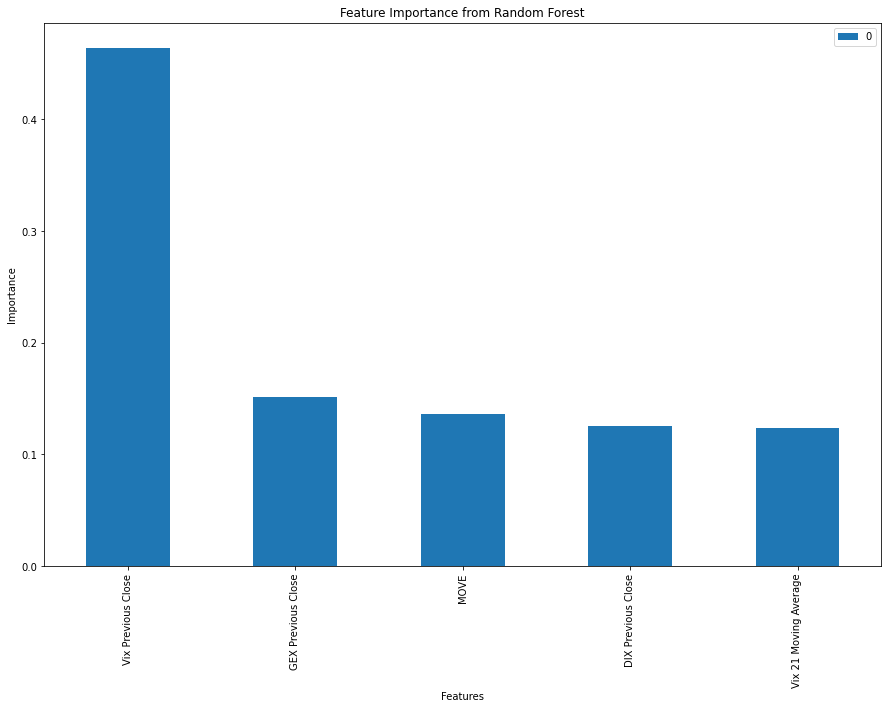

In [54]:
# Graph Importances

importances_df.sort_values(by = 0, ascending=False).plot(kind = "bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance from Random Forest")

In [ ]:
### Insight: For the model below, we wanted to see what the effect of Top of Book Liquidity would have on volatility. 
### We hypothesize that the less liquidity there is in markets, the more volatile the market is. Unfortunately, data
### for what we are trying to model here is very hard to obtain. Top of Book Liquidity data via the Chicago Mercantile
### Exchange (CME), was going to cost ~$19k if we wanted to capture the data that goes back to the May 31, 2011 start
### date in our other data collected above. Fortunately, the CME provides 2-year sample data we were able to use to at 
### least get a fraction of our time period. The results from that data are below. 


In [59]:
# Import CSV file and create DataFrame

top_of_book_df = pd.read_csv("iiiaaa.csv")

In [60]:
top_of_book_df

,date,price,Vix Previous Close,Vix 21 Moving Average,SPX Change,DIX Previous Close,GEX Previous Close,MOVE,Top of Book
0,11/16/20,3626.910000,23.100000,29.720476,0.011648,0.431061,6.032393e+09,42.490002,51.7
1,11/17/20,3609.530000,22.450001,29.412381,-0.004792,0.414971,5.568672e+09,43.080002,64.2
2,11/18/20,3567.800000,22.709999,29.150000,-0.011561,0.440556,5.804662e+09,43.619999,73.1
3,11/19/20,3581.850000,23.840000,28.886190,0.003938,0.416999,3.498179e+09,43.529999,51.9
4,11/20/20,3557.540000,23.110001,28.676190,-0.006787,0.438597,5.497968e+09,42.310001,54.5
...,...,...,...,...,...,...,...,...,...
496,11/4/22,3770.550049,25.299999,29.209524,0.013619,0.442476,-6.368992e+08,128.440002,22.1
497,11/7/22,3806.800049,24.549999,28.875714,0.009614,0.425303,5.863258e+08,128.330002,32.5
498,11/8/22,3828.110107,24.350000,28.546667,0.005598,0.449861,1.164755e+09,126.330002,39.2
499,11/9/22,3748.570068,25.540001,28.187619,-0.020778,0.438960,1.395167e+09,124.400002,29.2


In [61]:
# Drop Columns

top_of_book_df.drop(columns=["date", "price"], inplace=True)

In [62]:
# Create column with Absolute SPX move

top_of_book_df["SPX Move"] = top_of_book_df["SPX Change"].abs()

In [64]:
# Drop Columns

top_of_book_df.drop(columns=["SPX Change"], inplace=True)

In [65]:
# Create column that tracks the 7-day rolling average of Top of Book Depth

top_of_book_df["TOB Rolling"] = (top_of_book_df["Top of Book"].rolling(7).mean())

In [66]:
# Drop Columns

top_of_book_df.drop(columns=["Top of Book"], inplace=True)

In [67]:
# Drop Null Values

top_of_book_df.dropna(inplace=True)

In [68]:
# Set Y Variable

y = top_of_book_df["SPX Move"]

In [70]:
# Set X Variable

X = top_of_book_df.drop(columns=["SPX Move"])

In [71]:
# Split train and test data

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [72]:
# Scale Data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [73]:
# Call Model

model = RandomForestRegressor()

In [74]:
# Fit Model

model.fit(X_train,y_train)

RandomForestRegressor()

In [75]:
# Make Predictions

y_pred = model.predict(X_test)

In [78]:
# View Model Score

model.score(X,y)

0.6985988554246233

In [79]:
# Create Feature Importances

importances_names = model.feature_names_in_

In [80]:
# Model Importances

importances=model.feature_importances_

In [81]:
# Create DataFrame of Importances

importances_df = pd.DataFrame(importances,importances_names)

In [82]:
# Sort Importances by Value

importances_df.sort_values(by=0, ascending=False)

,0
TOB Rolling,0.219187
MOVE,0.190434
Vix Previous Close,0.179699
GEX Previous Close,0.152654
DIX Previous Close,0.129119
Vix 21 Moving Average,0.128907


Text(0.5, 1.0, 'Feature Importance from Random Forest')

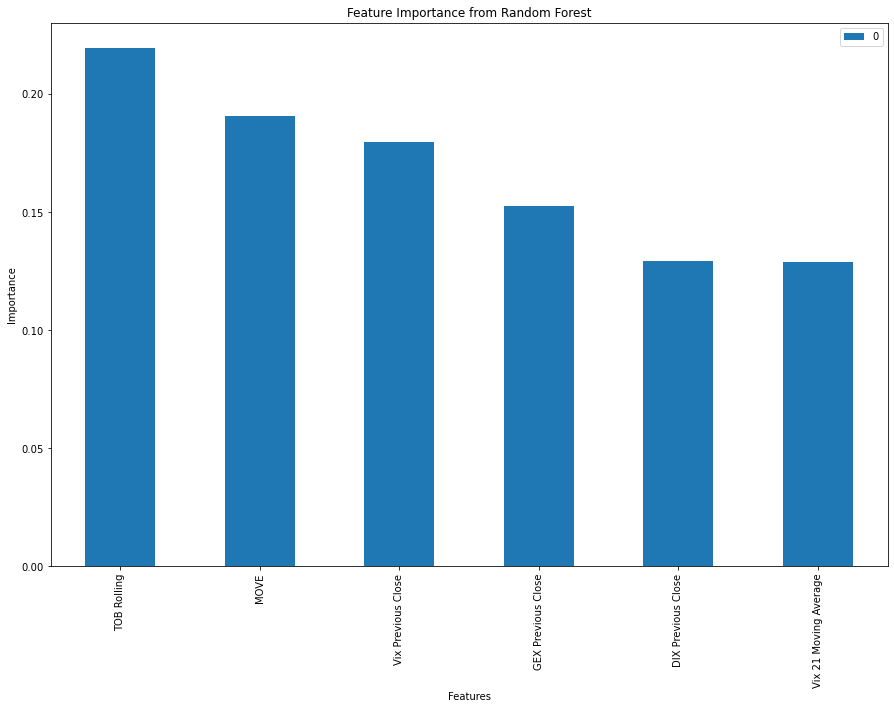

In [84]:
# Graph Importances

importances_df.sort_values(by = 0, ascending=False).plot(kind = "bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance from Random Forest")

In [ ]:
### There are several interesting ideas to take away from this model. The model had an RMSE score of about 0.7, which
### is slightly less than the previous model's score of about 0.75 . One of the key takeaways, from this model is that
### the time snapshot of the data we were able to obtain, did not feature the major volatility events of 2008, 2018, 
### or 2020. It would have been interesting to see what factor liquidity levels would have had during those highly 
### volatile time periods. Next, we can see that through the feature importance tool that our hypothesis was correct
### in believing that the liquidity, measured by the Top of Book liquidity level, was a major factor in determining
### the levels of realized volatility. As liquidity decreases, the level of volatility increases, and vice-versa. 
### Another key takeaway here, is just the general fluidity and ever-changing mechanics of the stock market. On our
### previous model, factors such as the various VIX measuring instruments played a much more important role in 
### determining volatilty. In this much more narrow model with less data, factors such as treasury market volatility
### (MOVE) were more central to determining market volatility. This coincides with the overall Treasury Market weakness
### we have experienced for a large part of 2022. We believe that had we had data that would have spanned the course
### of the major 2008, 2018, and 2020 volatility events, this feature importance model would have placed more emphasis
### on our various VIX measuring metrics. 
